In [3]:
import sys
sys.path.append('../')
import importlib
import model.op
importlib.reload(model.op)
from model.op import number_aircrafts_lp, number_aircrafts_lp_charge_full, number_aircrafts_lp_full_charge_under20

## Default parameters in LP

- Timestep: 5 min

- Flight time tau: 2 timesteps

- Kappa: 10% charge, 4 levels of SOC

- Gamma: 32 SOCs


# Run LP

In [16]:
number_aircrafts_lp_full_charge_under20(schedule='schedule_10min_0610', schedule_time_step=288, output_path='schedule_10min_0610_charge_full_under')

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i9-9980HK CPU @ 2.40GHz
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 291190 rows, 345708 columns and 973046 nonzeros
Model fingerprint: 0xef8c7239
Variable types: 0 continuous, 345708 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 271805 rows and 273869 columns
Presolve time: 0.82s
Presolved: 19385 rows, 71839 columns, 156927 nonzeros
Variable types: 0 continuous, 71839 integer (0 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    8016    5.8147706e+00   2.878469e+02   6.934160e+10      5s
   14386    1.1692194e+01   1.738797e+02   2.874068e+10     10s
   2132

# LP Output Visualization

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import seaborn as sns
import model.ParseLP
importlib.reload(model.ParseLP)
from model.ParseLP import convert2df, calculate_num_aircrafts

In [41]:
tau_list = [[[0, 5.92], [5.85, 0]], # 12
            [[0, 9.82], [10.59, 0]], # 24
            [[0, 13.40], [13.59, 0]], # 36
            [[0, 19.35], [19.39, 0]], # 48
            [[0, 23.47], [23.67, 0]], # 60
            [[0, 28.19], [28.20, 0]], # 72
            [[0, 32.17], [32.39, 0]], # 84
            [[0, 36.50], [36.75, 0]], # 96
            [[0, 41.40], [41.37, 0]]] # 108
tau_arry = np.array(tau_list)
tau_arry = np.ceil(tau_arry / 5)

In [75]:
kappa_list = [[[0, 12.35], [11.91, 0]],
              [[0, 16.04], [17.11, 0]],
              [[0, 18.88], [19.06, 0]],
              [[0, 26.52], [26.71, 0]],
              [[0, 30.35], [31.09, 0]],
              [[0, 36.31], [36.40, 0]],
              [[0, 39.58], [40.16, 0]],
              [[0, 44.05], [44.72, 0]],
              [[0, 50.86], [50.71, 0]]]
kappa_arry = np.array(kappa_list)
kappa_arry = np.ceil(kappa_arry / 2.5)

In [159]:
output_file = 'output_108_miles_10min'
specificn, specificu, specificc = convert2df(output_file)

In [160]:
# Obtain Airport Specific Aircraft States
specificu01 = specificu[specificu['i'] == 0].reset_index(drop=True)
specificu10 = specificu[specificu['i'] == 1].reset_index(drop=True)

specificc01 = specificc[specificc['i'] == 0].reset_index(drop=True)
specificc10 = specificc[specificc['i'] == 1].reset_index(drop=True)

specificn01 = specificn[specificn['i'] == 0].reset_index(drop=True)
specificn10 = specificn[specificn['i'] == 1].reset_index(drop=True)

In [161]:
(771.0) / (specificu01['amount'].sum() + specificu10['amount'].sum())

0.9028103044496487

In [129]:
tau_arry[1].astype(int)

array([[0, 2],
       [3, 0]])

In [130]:
len(tau_arry)

9

In [131]:
lax_all_c, lax_all_n, lax_all_u = calculate_num_aircrafts(specificc01, specificu01, specificn01, flight_time=tau_arry[8].astype(int))
dtla_all_c, dtla_all_n, dtla_all_u = calculate_num_aircrafts(specificc10, specificu10, specificn10, flight_time=tau_arry[8].astype(int))
all_c, all_n, all_u = calculate_num_aircrafts(specificc, specificu, specificn, flight_time=tau_arry[8].astype(int))

# State Visulization

22.0


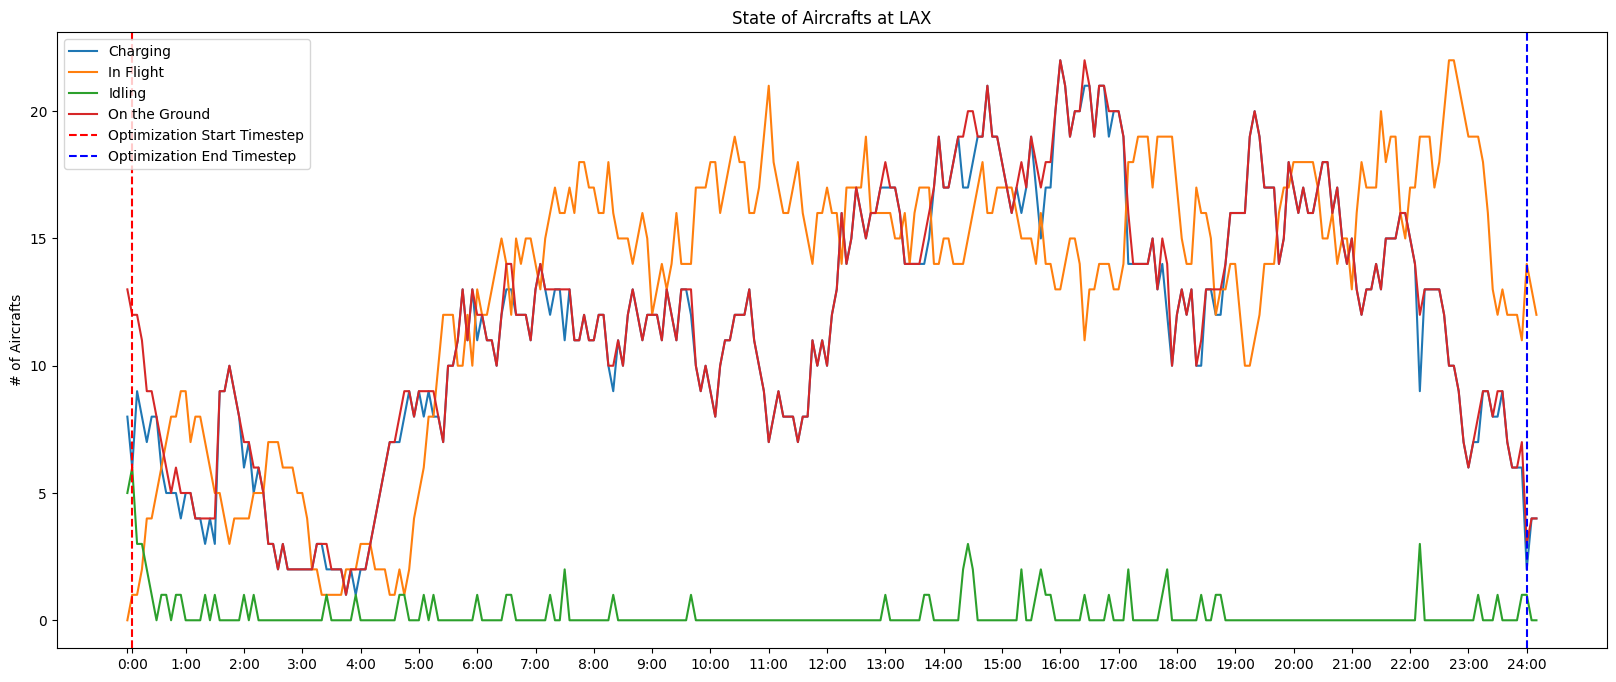

In [132]:
x0 = 0
x1 = 291

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(lax_all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(lax_all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(lax_all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((lax_all_c.sum(axis=0)[x0:x1] + lax_all_n.sum(axis=0)[x0:x1]), label='On the Ground', ax=ax)
ax.axvline(x=1, color='red', linestyle='--', label='Optimization Start Timestep')
ax.axvline(x=288, color='blue', linestyle='--', label='Optimization End Timestep')
ax.set(title='State of Aircrafts at LAX',
       ylabel='# of Aircrafts',
       xticks=np.concatenate([np.array([0,1]), np.arange(12,300, 12)]),
       xticklabels=['']+[str(i)+':00' for i in range(0,25)])
plt.legend(loc='upper left');
print(max((lax_all_c.sum(axis=0)[x0:x1] + lax_all_n.sum(axis=0)[x0:x1])))

In [133]:
print('At t = 0, c =', lax_all_c.sum(axis=0)[x0:x1][0], '; u=', lax_all_u.sum(axis=0)[x0:x1][0], '; n=', lax_all_n.sum(axis=0)[x0:x1][0])
print('At t = 290, c =', lax_all_c.sum(axis=0)[x0:x1][286], '; u=', lax_all_u.sum(axis=0)[x0:x1][286], '; n=', lax_all_n.sum(axis=0)[x0:x1][286])

At t = 0, c = 8.0 ; u= 0.0 ; n= 5.0
At t = 290, c = 6.0 ; u= 12.0 ; n= 0.0


54.0


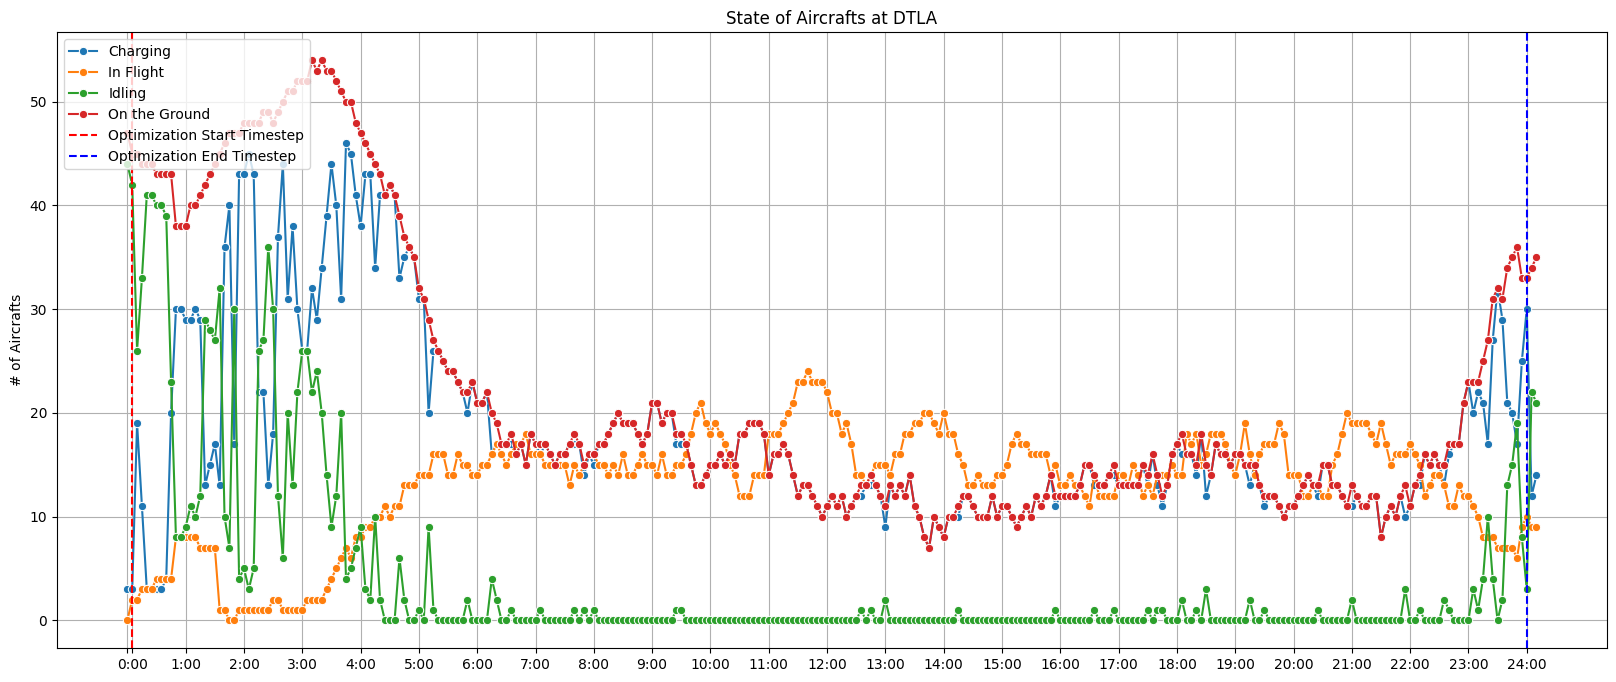

In [134]:
x0 = 0
x1 = 291

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(dtla_all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax, marker='o')
sns.lineplot(dtla_all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax, marker='o')
sns.lineplot(dtla_all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax, marker='o')
sns.lineplot((dtla_all_c.sum(axis=0)[x0:x1] + dtla_all_n.sum(axis=0)[x0:x1]), label='On the Ground', ax=ax, marker='o')
ax.axvline(x=1, color='red', linestyle='--', label='Optimization Start Timestep')
ax.axvline(x=288, color='blue', linestyle='--', label='Optimization End Timestep')
ax.set(title='State of Aircrafts at DTLA',
       ylabel='# of Aircrafts',
       xticks=np.concatenate([np.array([0,1]), np.arange(12,300, 12)]),
       xticklabels=['']+[str(i)+':00' for i in range(0,25)])
plt.legend(loc='upper left');
plt.grid()
print(max(dtla_all_c.sum(axis=0)[x0:x1] + dtla_all_n.sum(axis=0)[x0:x1]))

In [135]:
print('At t = 0, c =', dtla_all_c.sum(axis=0)[x0:x1][0], '; u=', dtla_all_u.sum(axis=0)[x0:x1][0], '; n=', dtla_all_n.sum(axis=0)[x0:x1][0])
print('At t = 290, c =', dtla_all_c.sum(axis=0)[x0:x1][290], '; u=', dtla_all_u.sum(axis=0)[x0:x1][290], '; n=', dtla_all_n.sum(axis=0)[x0:x1][290])

At t = 0, c = 3.0 ; u= 0.0 ; n= 44.0
At t = 290, c = 14.0 ; u= 9.0 ; n= 21.0


60.0


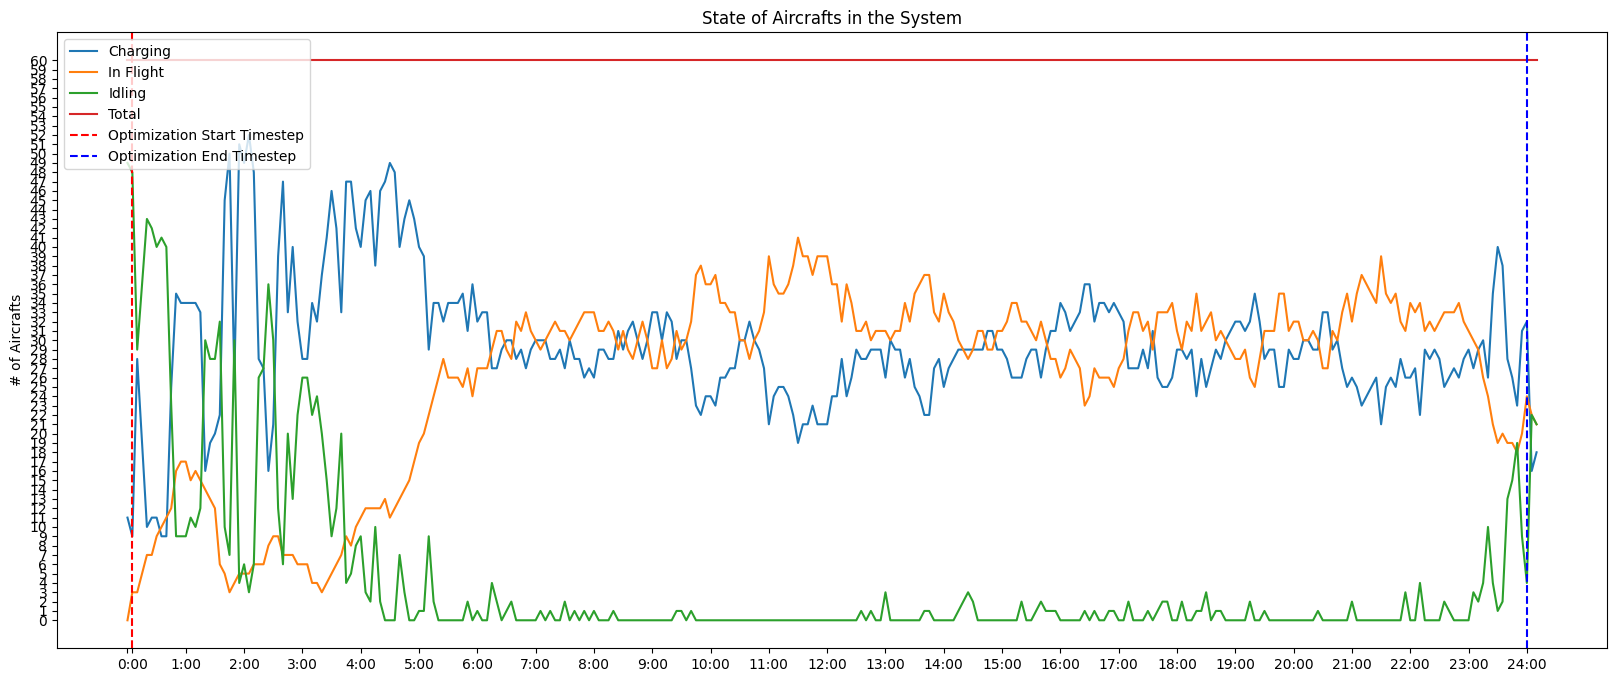

In [136]:
x0=0
x1=291

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((all_c.sum(axis=0)[x0:x1] + all_u.sum(axis=0)[x0:x1] + all_n.sum(axis=0)[x0:x1]), label='Total', ax=ax)
ax.axvline(x=1, color='red', linestyle='--', label='Optimization Start Timestep')
ax.axvline(x=288, color='blue', linestyle='--', label='Optimization End Timestep')
ax.set(title='State of Aircrafts in the System',
       ylabel='# of Aircrafts',
       yticks=np.arange(0, (all_c.sum(axis=0)[x0:x1] + all_u.sum(axis=0)[x0:x1] + all_n.sum(axis=0)[x0:x1])[0]+1),
       xticks=np.concatenate([np.array([0,1]), np.arange(12,300, 12)]),
       xticklabels=['']+[str(i)+':00' for i in range(0,25)])
plt.legend(loc='upper left');
# plt.xlim([0, 10])
print(max((all_c.sum(axis=0)[x0:x1] + all_u.sum(axis=0)[x0:x1] + all_n.sum(axis=0)[x0:x1])))

In [137]:
print('At t = 0, c =', all_c.sum(axis=0)[x0:x1][0], '; u=', all_u.sum(axis=0)[x0:x1][0], '; n=', all_n.sum(axis=0)[x0:x1][0])
print('At t = 290, c =', all_c.sum(axis=0)[x0:x1][290], '; u=', all_u.sum(axis=0)[x0:x1][290], '; n=', all_n.sum(axis=0)[x0:x1][290])

At t = 0, c = 11.0 ; u= 0.0 ; n= 49.0
At t = 290, c = 18.0 ; u= 21.0 ; n= 21.0
